In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/e_psf_grid_psimax-3_bins-25_KDE.pckl
running gaussian-process resolution smoothing
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [3]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp, poisson_llh, get_scaler
from tqdm import tqdm


# Settings

In [4]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"),
    "improved-50": join(LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"),
}

# plot settings for different configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# helper functions

In [5]:
def scaling_estimation(df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5):
    """ Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors """

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new
        
    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1
    
    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [6]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])


# Atmospheric background
Actually, we would need to account for the different zenith regions of a source, if the detector is not at one of the poles.
This is currently not yet implemented

In [7]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


# Energy resolution function

In [8]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1) # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1) # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))


Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


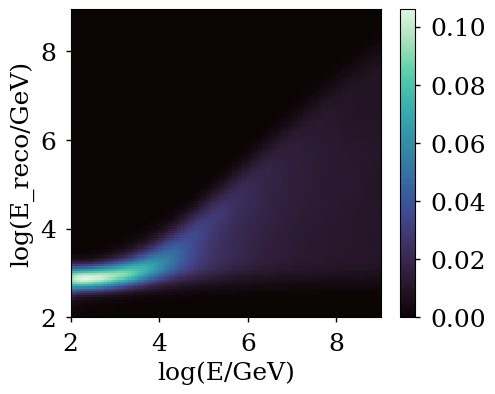

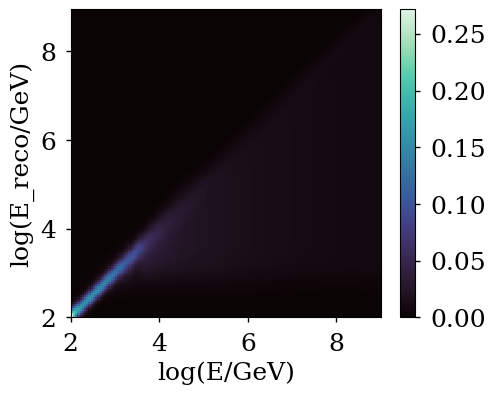

In [9]:
# full range, easy plotting
baseline_eres.plot()
improved_eres.plot()


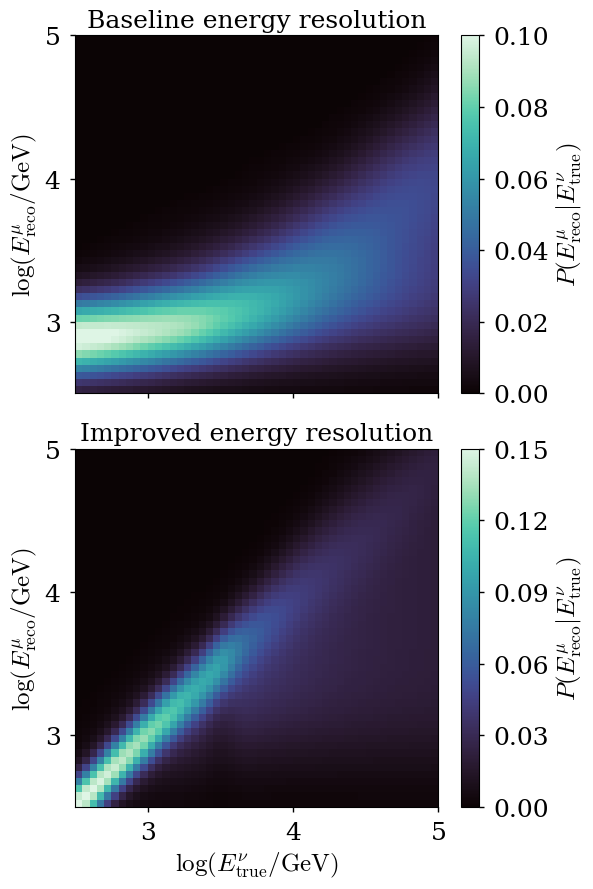

In [10]:
ebounds = (2.5, 5)

f, axes = plt.subplots(nrows=2, figsize=(6, 9), sharex=True)
f, ax = mephisto.plot_mephistogram(baseline_eres, f=f, ax=axes[0], vmin=0, vmax=0.1)
ax.set_xlabel("")
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.collections[0].colorbar.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
ax.set_title("Baseline energy resolution")
ax.set_yticks([3, 4, 5])

f, ax = mephisto.plot_mephistogram(improved_eres, f=f, ax=axes[1], vmin=0, vmax=0.15)
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.set_xlabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
cb = ax.collections[0].colorbar
cb.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
cb.set_ticks(np.arange(0, 0.16, step=0.03))
ax.set_title("Improved energy resolution")
ax.set_yticks([3, 4, 5])

f.tight_layout()
f.savefig(join(BASEPATH, "plots/ngc_paper/energy_resolution_comparison.pdf"))


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [11]:
# angular resolution
with open(join(LOCALPATH, "Psi2_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

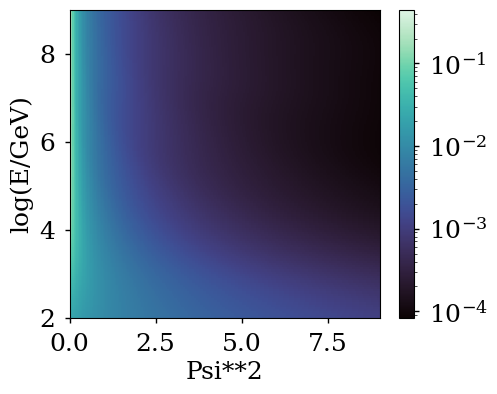

In [12]:
e_psi2_grid.plot(norm=LogNorm())

# Flux definition

In [13]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 source parameters

In [14]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(join(LOCALPATH, "tenyr_paper_68_contour.txt"))

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [15]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


## Check event numbers

In [16]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


ngc 1068: 85.75926927315574


## PL+Cut: source parameters

In [17]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
Gamma_cut = 2.0
logE_cut = 3.5 # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(
    PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


### scale the fluxes such that the event numbers match


In [18]:
## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut) 
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


flux_scaling_cut 1.4516980030327629
flux normalization before 5e-14 after 7.258490015163814e-14


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [21]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    energy_resolution,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        get_mids(np.power(10, mu_s_base.bins[1])),
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return poisson_llh(mu_i, k_i)


# NGC 1068
## Significance test Background vs. Background + Signal

In [24]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)
    print("=" * 10)

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], bckg_histo["IceCube"].bin_mids[0], axis=1
        ),
        energy_resolution=baseline_eres,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=get_mids(np.power(10, aeff_factor_signal.bins[1])),
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=ngc_flux,  # powerlaw
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    dct = dict(
        shape="powerlaw",
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=baseline_eres,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval/2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()


IceCube
Asimov data sum:
Background: 1173.8907835190093
Signal: 85.75926927315574
Atmo-only normalization: [1.07304711]
Signal fit parameters: [1.  1.  3.2]
TS check: -320367.49123285373 (fit:  -320367.49123285373 )
-2 Delta LLH: 20.549352762289345
P-VALUE: 3.4495682691144156e-05 SIGNIFICANCE: 3.9797376381174936

Plenum-1
Asimov data sum:
Background: 4949.2231268225605
Signal: 364.245537989893
Atmo-only normalization: [1.07359636]
Signal fit parameters: [1.  1.  3.2]
TS check: -288283.40608664334 (fit:  -288283.40608664334 )
-2 Delta LLH: 82.08611399470828
P-VALUE: 1.4970173220386918e-18 SIGNIFICANCE: 8.711680161213385

Plenum-2
Asimov data sum:
Background: 12552.213105413419
Signal: 919.6863626469169
Atmo-only normalization: [1.07326888]
Signal fit parameters: [1.  1.  3.2]
TS check: -254822.2778427396 (fit:  -254822.2778427396 )
-2 Delta LLH: 215.15712171877385
P-VALUE: 1.9020619058009013e-47 SIGNIFICANCE: 14.421245988713409



## test with pseudo experiments

In [25]:
from scipy.stats import poisson

In [40]:
ident = "IceCube"

aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
if "Plenum" in ident or "P-ONE" in ident:
    aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
    aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
# asimov data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(
        ngc_src_config["dec"], bckg_histo["IceCube"], bckg_histo["IceCube"].bin_mids[0], axis=1
    ),
    energy_resolution=baseline_eres,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=get_mids(np.power(10, aeff_factor_signal.bins[1])),
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
TS = []
pvals = []
for _ in range(1000):
    if _==0:
        k_s_PE = k_s
    else:
        k_s_PE = poisson.rvs(mu=k_s.histo)
    k_i = k_s_PE + k_b

    dct = dict(
        shape="powerlaw",
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=baseline_eres,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    #print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    #print("Signal fit parameters:", out_comp[0])
    #print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    #print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)

    TS.append(out_bckg[1] - out_comp[1])
    pvals.append(pval)
    # significance = norm.isf(pval/2)
    #print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    #print()


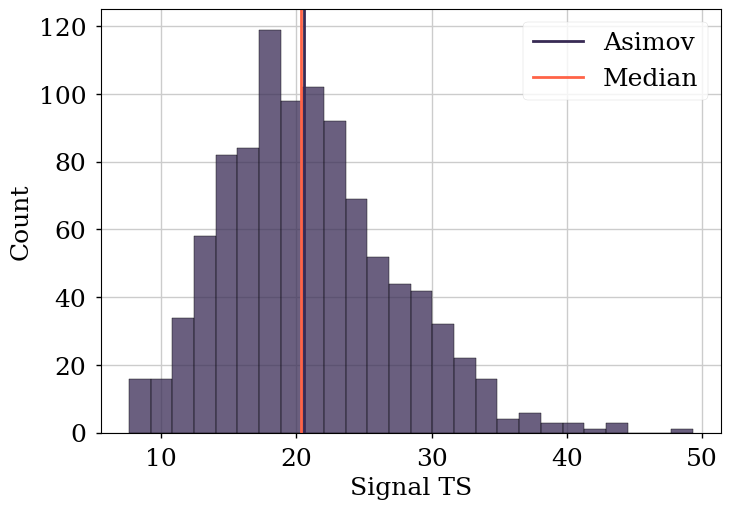

In [42]:
ax = sns.histplot(TS[1:])
ax.axvline(TS[0], label="Asimov")
ax.axvline(np.median(TS[1:]), label="Median", color="tomato")
ax.set_xlabel("Signal TS")
plt.legend()

# Power law vs. Power-law with cutoff

### Significance

In [44]:
pvals_ngc = []
identifier = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[identifier], **ngc_bg_config) * 10
aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], **ngc_src_config) * 10

# asimov data
k_b = atmo_background(
    aeff_factor_bckg,
    array_source_interp(ngc_src_config["dec"], bckg_histo["IceCube"], sindec_mids, axis=1),
    energy_resolution=improved_eres,
)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    improved_eres,
    1,
    ngc_cut_flux,  # powerlaw with cutoff
)
TS = []
pvals = []
for _ in range(100):
    if _==0:
        k_s_PE = k_s
    else:
        k_s_PE = poisson.rvs(mu=k_s.histo)
    k_i = k_s_PE + k_b

    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
        energy_resolution=improved_eres,
    )
    pl_func = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 1.2, 3.0),
        approx_grad=True,
    )
    #print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    #print("global params:", out_comp[0])
    #print("true params:", (1, 1, Gamma_cut, logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, Gamma_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    TS.append(out_bckg[1] - out_comp[1])
    pvals.append(pval)



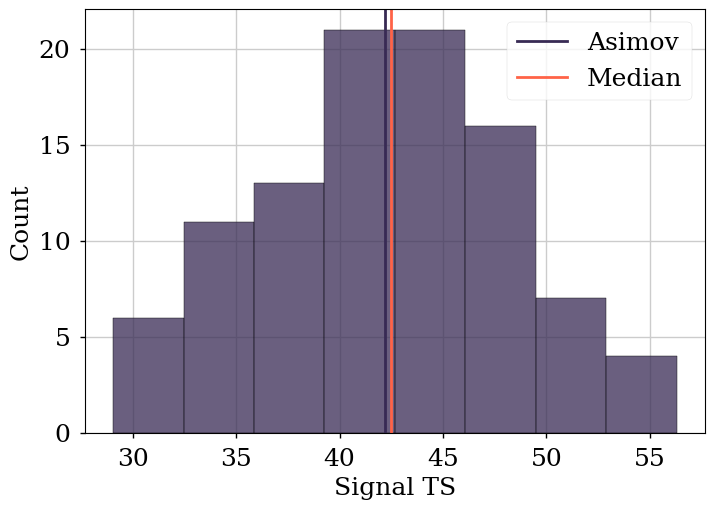

In [45]:
ax = sns.histplot(TS[1:])
ax.axvline(TS[0], label="Asimov")
ax.axvline(np.median(TS[1:]), label="Median", color="tomato")
ax.set_xlabel("Signal TS")
plt.legend()

### Nice significance summary plot

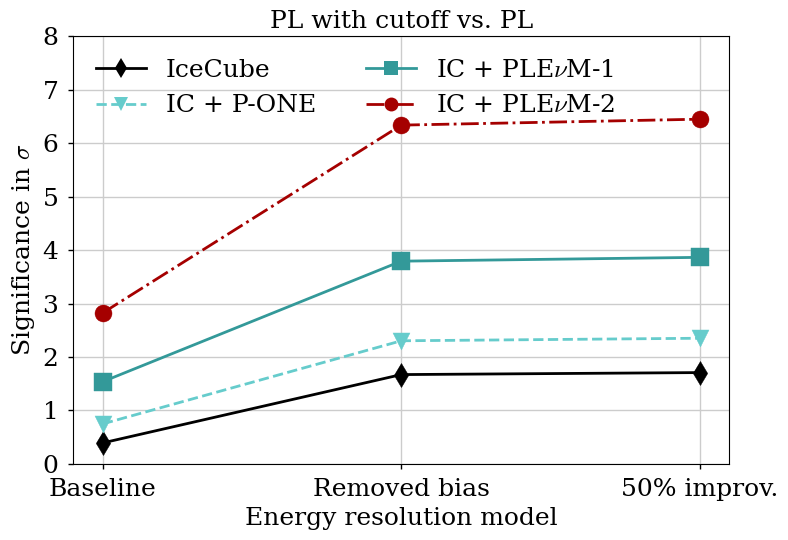

In [32]:
pval_df = pd.read_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))
f, ax = plt.subplots()
for ident, series in pval_df.groupby(["key"]):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=det_plotting[ident]["ls"],
        color=det_plotting[ident]["color"],
        marker=det_plotting[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[det_plotting[ident]["color"]],
        s=150,
        zorder=10,
        marker=det_plotting[ident]["marker"],
    )

ax.set_ylim(0, 8)
ax.legend(loc=2, ncol=2, frameon=False) #, fontsize="large")
ax.set_title("PL with cutoff vs. PL") #, fontsize=18)
ax.set_xlabel("Energy resolution model") #, fontsize=18)
ax.set_ylabel(r"Significance in $\sigma$") #, fontsize=18)
f.tight_layout()
f.savefig(join(BASEPATH, "plots/ngc_paper/cutoff_sigma_vs_eres_ngc.pdf"))


## spectral fit vs. dec

scan for right threshold

In [33]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-90, 91, step=5)
num = 20

thresholds = [sigma3, 0.01, 0.1]
tmp = []
for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], dec=dec, **bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dec=dec, **src_config)
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_bckg += calc_aeff_factor(
                aeff_2d["IceCube"], dec=dec, **bg_config
            )
            aeff_factor_signal += calc_aeff_factor(
                aeff_2d["IceCube"], dec=dec, **src_config
            )

        # asimov data
        # improved energy resolution
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, bckg_histo, sindec_mids, axis=1),
            energy_resolution=improved_eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            energy_resolution=improved_eres,
            phi_scaling=1,
            flux_shape=ngc_cut_flux,
        )
        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        while len(current_thresholds) > 0:

            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                energy_resolution=improved_eres,
                phi_scaling=scaler,
                flux_shape=ngc_cut_flux,
            )
            k_i = k_s + k_b

            dct = dict(
                mu_b_base=k_b,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=ngc_cut_flux.E0,
                phi_0=ngc_cut_flux.norm, 
                energy_resolution=improved_eres,
            )
            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_2d_composite(
                x, shape="powerlaw with cutoff", **dct
            )
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(0, 10), (0, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, scaler, Gamma_cut, logE_cut),
                approx_grad=True,
            )
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
                "n_sig": np.sum(k_s),
                "out_bg": out_bckg,
                "out_comp": out_comp,
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 1)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask],
                current_thresholds,
                scaler,
                stop_here=0.2,
                stepper=2,
                min_steps=1,
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))


100%|██████████| 37/37 [03:14<00:00,  5.27s/it]


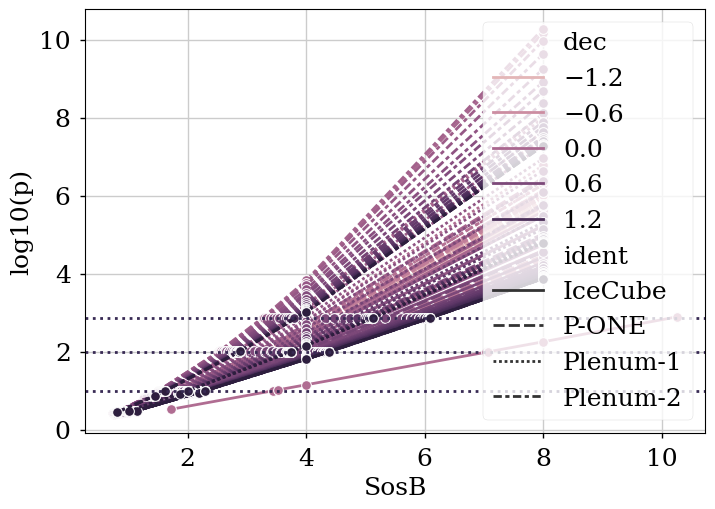

In [34]:
thresholds = [sigma3, 0.01, 0.1]
xname = "SosB" # "scaler" # 
ax = sns.lineplot(
    data=df, y="log10(p)", x=xname, marker="o", hue="dec", style="ident")
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")
plt.legend()

## plotting


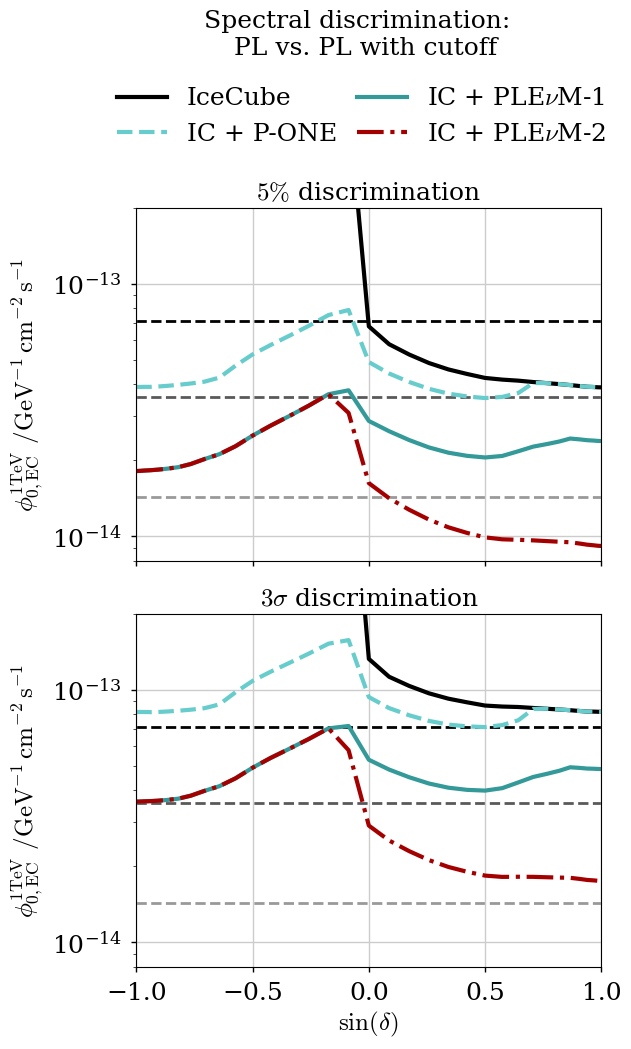

In [35]:
df = pd.read_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3)) * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01)) * ngc_cut_flux.norm
flux["5%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05)) * ngc_cut_flux.norm
flux["10%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
flux = flux.reset_index()

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot various thresholds
f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)
for ident, series in flux.groupby(["ident"]):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3, 
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_ylabel(
        r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
        fontsize=18,
    )
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    #fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[1].set_xlabel(r"$\sin(\delta)$", fontsize=18)
f.subplots_adjust(hspace=0.15, top=0.8)
f.suptitle("Spectral discrimination: \n PL vs. PL with cutoff", fontsize=18)
f.savefig(join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot.pdf"), bbox_inches="tight")


# Further Checks

## Time scaling

Check how the discovery potential scales with time

### standard PS

In [36]:
tmp = []  # save output here
thresholds = [sigma5]
decs = np.arange(0, 81, step=20)
test_fluxes = [
    PL_flux(5E-14, 3.2, 1E3, "powerlaw"), # ngc-like
    PL_flux(2.7E-20, 2.0, 1E5, "powerlaw"), # txs-like
]

ident = "IceCube"
livetime_scaling = np.logspace(-0.1, 1, num=5)

for lt, dec, tmp_flux in tqdm(product(livetime_scaling, np.deg2rad(decs), test_fluxes)):

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], dec=dec, **bg_config) * lt # livetime scaling
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dec=dec, **src_config) * lt # livetime scaling

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(dec, bckg_histo, sindec_mids, axis=1),
        energy_resolution=improved_eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        improved_eres,
        1,
        tmp_flux,  # powerlaw
    )
    # calculate an estimate for the flux scaling
    scaler = 4 if tmp_flux.gamma==3.2 else 1
    scaler /= (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    count = 0
    while len(current_thresholds) > 0:
        
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            improved_eres,
            scaler,
            tmp_flux,  # powerlaw
        )
        k_i = k_s + k_b

        dct = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=tmp_flux.E0,
            phi_0=tmp_flux.norm,
            energy_resolution=improved_eres,
        )
        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, tmp_flux.gamma),
            approx_grad=True,
        )

        tmp_dct = {
            "ident": ident,
            "dec": dec,
            "livetime_scaling": lt,
            "gamma": tmp_flux.gamma,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(k_s),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.ident == ident)
            & (tmp_df.livetime_scaling == lt)
            & (tmp_df.gamma == tmp_flux.gamma)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "livetime_scaling_disc_pot.pickle"))


50it [01:04,  1.28s/it]


In [37]:
flux = pd.DataFrame(
    df.groupby(["ident", "dec", "gamma", "livetime_scaling"]).apply(lambda x: get_scaler(x, sigma5)),
    columns=["disc5"],
).reset_index()

[]

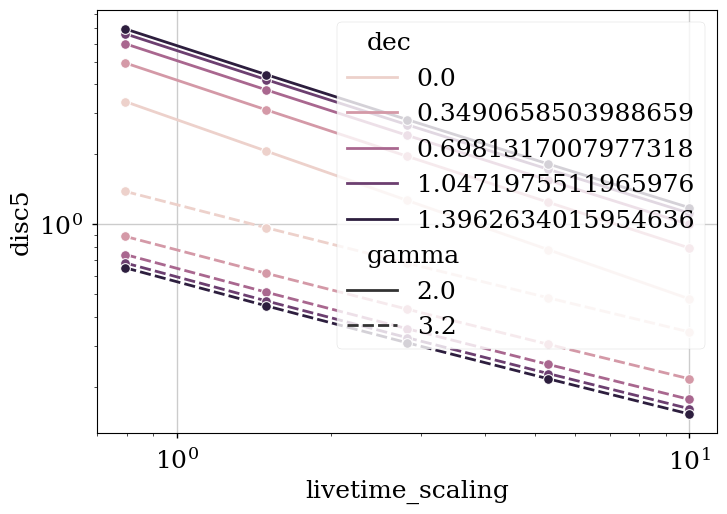

In [38]:
ax = sns.lineplot(data=flux, x="livetime_scaling", y="disc5", hue="dec", style="gamma", marker="o")
ax.loglog()

<AxesSubplot: xlabel='dec', ylabel='pl_index'>

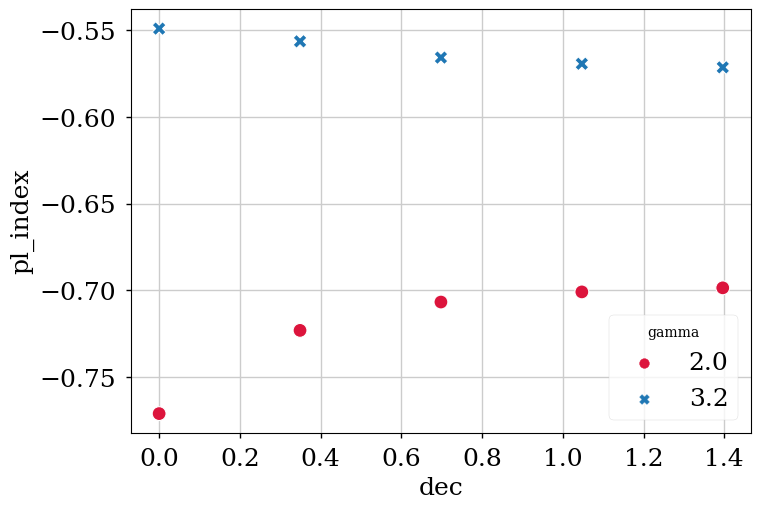

In [39]:
pl_indices = pd.DataFrame(
    flux.groupby(["dec", "gamma", "ident"]).apply(
        lambda x: np.polyfit(np.log10(x.livetime_scaling), np.log10(x.disc5), 1)[0]
    ),
    columns=["pl_index"],
)
sns.scatterplot(
    data=pl_indices,
    x="dec",
    y="pl_index",
    style="gamma",
    hue="gamma",
    palette=["crimson", "tab:blue"],
    s=100,
)


### Spectral

In [40]:
tmp = []  # save output here
thresholds = [sigma3]
decs = [0] #np.arange(0, 81, step=20)
ident = "IceCube"
livetime_scaling = np.logspace(-0.1, 1, num=15)

for lt, dec in tqdm(product(livetime_scaling, np.deg2rad(decs))):

    aeff_factor_bckg = (
        calc_aeff_factor(aeff_2d[ident], dec=dec, **bg_config) * lt
    )  # livetime scaling
    aeff_factor_signal = (
        calc_aeff_factor(aeff_2d[ident], dec=dec, **src_config) * lt
    )  # livetime scaling

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(dec, bckg_histo, sindec_mids, axis=1),
        energy_resolution=improved_eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        energy_resolution=improved_eres,
        phi_scaling=1,
        flux_shape=ngc_cut_flux,
    )
    # calculate an estimate for the flux scaling
    scaler = 8 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:

        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            energy_resolution=improved_eres,
            phi_scaling=scaler,
            flux_shape=ngc_cut_flux,
        )
        k_i = k_s + k_b

        dct = dict(
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=ngc_cut_flux.E0,
            phi_0=ngc_cut_flux.norm,
            energy_resolution=improved_eres,
        )
        # fix signal contribution to powerlaw
        local_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_2d_composite(
            x, shape="powerlaw with cutoff", **dct
        )
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2, 1.2, GAMMA_NGC),
            bounds=[(0, 10), (0, 10), (1, 5)],
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, scaler, Gamma_cut, logE_cut),
            approx_grad=True,
        )

        tmp_dct = {
            "dec": dec,
            "livetime_scaling": lt,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(k_s),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.livetime_scaling == lt)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "livetime_scaling_disc_pot_spectral.pickle"))


15it [00:21,  1.46s/it]


In [41]:
flux = pd.DataFrame(
    df.groupby(["dec", "livetime_scaling"]).apply(lambda x: get_scaler(x, sigma3)),
    columns=["disc3"],
).reset_index()

[]

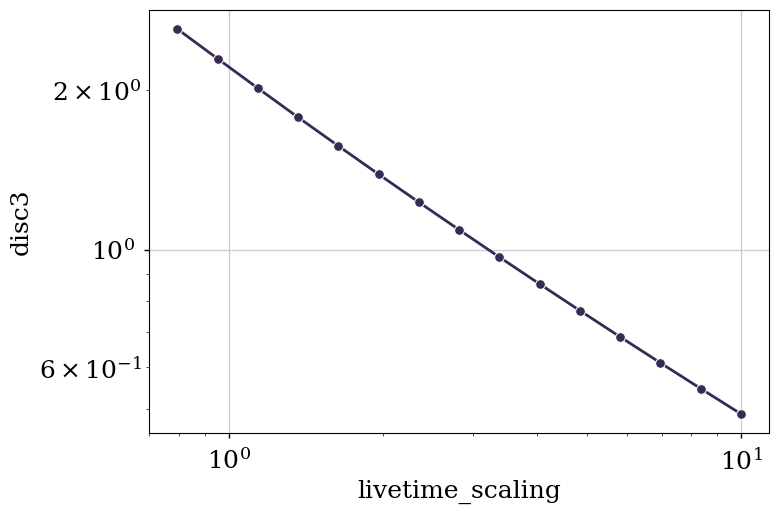

In [42]:
ax = sns.lineplot(data=flux, x="livetime_scaling", y="disc3", 
#hue="dec",
 marker="o")
ax.loglog()

In [43]:
pl_indices = pd.DataFrame(
    flux.groupby(["dec"]).apply(
        lambda x: np.polyfit(np.log10(x.livetime_scaling), np.log10(x.disc3), 1)[0]
    ),
    columns=["pl_index"],
)
print(pl_indices)


     pl_index
dec          
0.0 -0.660393


## Significance with improved PSF
We model the improved PSF simply with a background norm reduction. This implies that the shape of the PSF stays the same, but it's a reasonable estimate.

### find the characteristic angular scale

(0.0, 3.0)

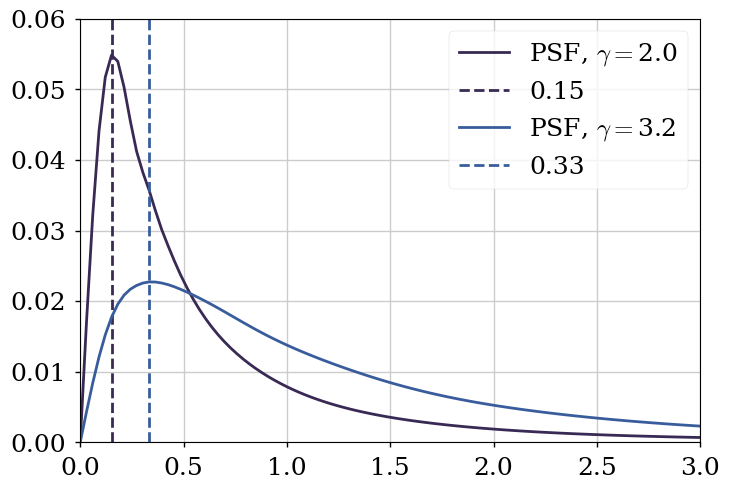

In [44]:
aeff_factor_signal = calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
psi_eval = np.linspace(0, 3, num=100)
modes = {}
for gamma in [2.0, 3.2]:
    tmp_flux = PL_flux(1e-14, gamma, 1e3, "powerlaw")

    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=tmp_flux,  # powerlaw
    )
    # transform from psi^2 back to psi to get an characteristic angular scale
    spl = InterpolatedUnivariateSpline(k_s.bin_mids[0], k_s.sum(axis=1))
    psf = 2 * psi_eval * spl(psi_eval**2)
    psf /= np.sum(psf)
    p = plt.plot(psi_eval, psf, label=rf"PSF, $\gamma=${gamma}")
    modes[gamma] = psi_eval[np.argmax(psf)]
    plt.axvline(modes[gamma], label=f"{modes[gamma]:1.2f}", ls="--", color=p[0].get_color())
plt.legend()
plt.ylim(0, 0.06)
plt.xlim(0, 3)


### scale the BG down to mimic a better PSF

In [45]:
idents = ["IceCube", "P-ONE", "Plenum-1"]
psf_scale = np.logspace(-1, 1, num=20)
psf_scale = np.sort(np.concatenate([[1], psf_scale]))
results = []

for ident, psf_s in product(idents, psf_scale):
    bg_r = psf_s**2  # background scales quadratically with the analysis window radius

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config) 
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg * bg_r, # scale BG
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=ngc_flux,  # powerlaw
    )
    k_i = k_s + k_b

    dct = dict(
        shape="powerlaw",
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=baseline_eres,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval/2)
    results.append(
        {
            "significance": significance,
            "pval": pval,
            "ident": f"IC + {ident}" if ident=="P-ONE" else ident,
            "bg_reduction": bg_r,
            "psf_improvement": psf_s,
        }
    )
results = pd.DataFrame(results)


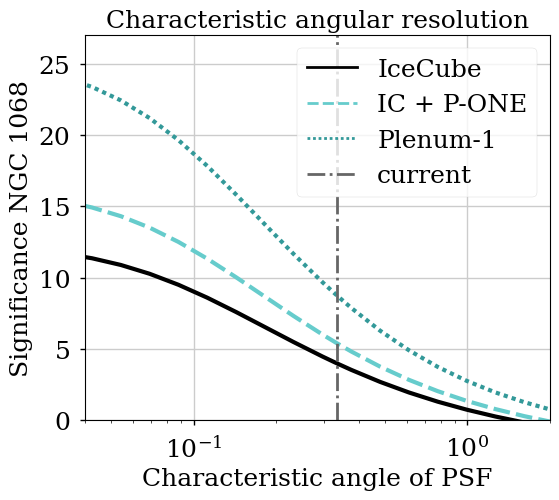

In [46]:
results["characteristic_ang"] = modes[3.2] * results["psf_improvement"]
plt.figure(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x="characteristic_ang",
    y="significance",
    style="ident",
    hue="ident",
    lw=3,
    palette=[det_plotting[ident]["color"] for ident in idents],
)
plt.axvline(modes[3.2], label="current", color="0.4", lw=2, ls="-.")
# plt.axhline(results.loc[(results.ident=="IceCube") & (results.bg_reduction==1)].significance.iloc[0], color="0.4", lw=2, ls="-.")
ax.set_xscale("log")
ax.set_xlim(0.04, 2)
ax.set_ylim(0, 27)
plt.legend(loc=1)
legend = ax.get_legend()
legend.set_title(None)
ax.set_title("Characteristic angular resolution")
ax.set_ylabel("Significance NGC 1068")
ax.set_xlabel("Characteristic angle of PSF")
plt.savefig(join(BASEPATH, "plots/ngc_paper/angular_improvement.pdf"))


## Significance test Background vs. Background + Signal with improved energy resolution

In [47]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
pvals_ngc = []
for ident in idents:
    print(ident)
    print("=" * 10)

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    for key in e_res_files:
        # energy smearing matrix
        with open(e_res_files[key], "rb") as f:
            eres = pickle.load(f)
        eres.normalize(axis=1)
        print(key)
        print("- " * 10)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
            energy_resolution=eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            energy_resolution=eres,
            phi_scaling=1,
            flux_shape=ngc_flux,  # powerlaw
        )
        k_i = k_s + k_b

        # define the fitting functions with all parameters
        # background only, 1 free parameter
        dct = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
            energy_resolution=eres,
        )
        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, **dct)
        # ... and fit both hypotheses!
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        print("Atmo-only normalization:", out_bckg[0])

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        print("Signal fit parameters:", out_comp[0])
        # print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

        # calculate p-value and significance with Wilks'
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = norm.isf(pval/2)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("")


        pvals_ngc.append(
        {
            "identifier": ident,
            "e_smearing": key,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )
pvals_ngc_df = pd.DataFrame(pvals_ngc)


IceCube
baseline
- - - - - - - - - - 
Atmo-only normalization: [1.07272193]
Signal fit parameters: [1.00007144 0.99969186 3.20009896]
P-VALUE: 3.208229567929625e-05 SIGNIFICANCE: 3.9969472523814558

reproduction
- - - - - - - - - - 
Atmo-only normalization: [1.0727227]
Signal fit parameters: [0.9999987  0.9999659  3.19993304]
P-VALUE: 3.05560517400878e-05 SIGNIFICANCE: 4.0084750126257

1:1
- - - - - - - - - - 
Atmo-only normalization: [1.07272098]
Signal fit parameters: [1.00005306 0.9999996  3.20000245]
P-VALUE: 2.2901919140856355e-05 SIGNIFICANCE: 4.076066939132558

improved-20
- - - - - - - - - - 
Atmo-only normalization: [1.07272098]
Signal fit parameters: [1.00005388 0.99994278 3.20006027]
P-VALUE: 2.2745123601552008e-05 SIGNIFICANCE: 4.077664993751675

improved-50
- - - - - - - - - - 
Atmo-only normalization: [1.07272189]
Signal fit parameters: [1.00005688 0.99991911 3.19990976]
P-VALUE: 2.2900849452107722e-05 SIGNIFICANCE: 4.076077806168318

Plenum-1
baseline
- - - - - - - - - -

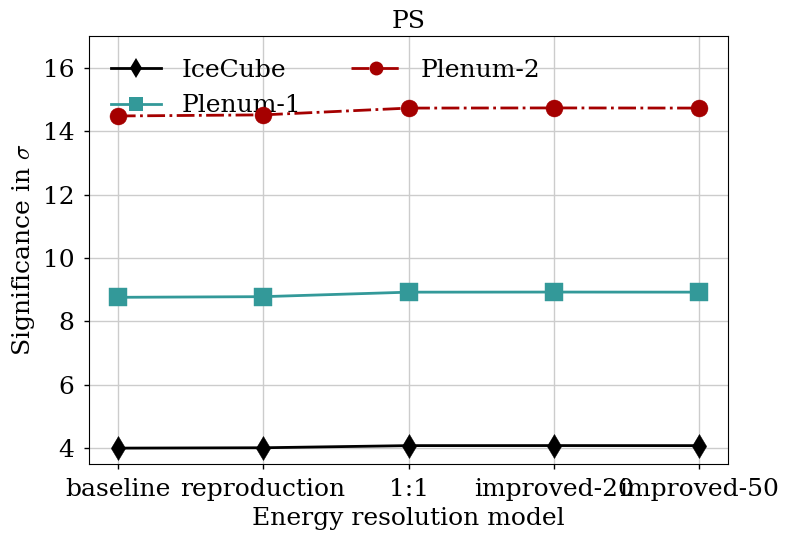

In [48]:
f, ax = plt.subplots()
for ident, series in pvals_ngc_df.groupby(["identifier"]):
    
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=det_plotting[ident]["ls"],
        color=det_plotting[ident]["color"],
        marker=det_plotting[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[det_plotting[ident]["color"]],
        s=150,
        zorder=10,
        marker=det_plotting[ident]["marker"],
    )

ax.set_ylim(3.5, 17)
ax.legend(loc=2, ncol=2, frameon=False)
ax.set_title("PS")
ax.set_xlabel("Energy resolution model")
ax.set_ylabel(r"Significance in $\sigma$")
f.tight_layout()
